In [1]:
import numpy as np
import os
from stompy.grid import unstructured_grid
import stompy.model.delft.dflow_model as dfm
import pandas as pd
from stompy import utils
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
import six
six.moves.reload_module(dfm)

<module 'stompy.model.delft.dflow_model' from '/home/rustyh/src/stompy/stompy/model/delft/dflow_model.py'>

In [3]:
#run_dir="data_2016long_3d_asbuilt_impaired_scen3-v004_r02"
#run_dir="data_2016long_3d_asbuilt_impaired_scen3_l100-v008"
#run_dir="data_2016long_3d_asbuilt_impaired_scen1-v002_r00"
#run_dir="data_2016long_3d_asbuilt_impaired_scen3_l100-v006"
#run_dir="data_2016long_3d_asbuilt_impaired_scen2-v004_r00"
run_dir="data_2016long_3d_asbuilt_impaired_scen2_l100-v005"

model=dfm.DFlowModel.load(run_dir)

In [72]:
base_dir="data_2016long_3d_asbuilt_impaired-v020"
model_base=dfm.DFlowModel.load(base_dir)

In [4]:
map_ds=model.map_dataset(xr_kwargs=dict(decode_times=False))

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


In [5]:
his_ds=model.his_dataset()

In [20]:
map_ds.time.values[23]

3974400.0

In [7]:
map_ds.time[-1]

<xarray.DataArray 'time' ()>
array(172800.)
Coordinates:
    time     float64 1.728e+05
Attributes:
    standard_name:  time
    units:          seconds since 2016-07-01 00:00:00 +00:00

<IPython.core.display.Javascript object>


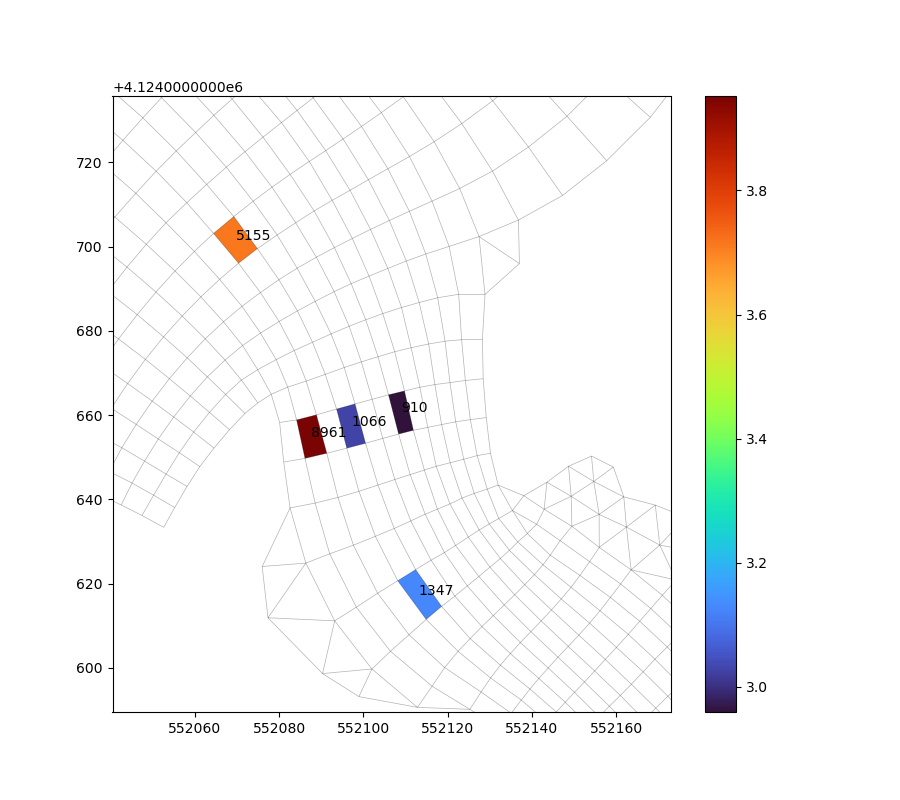

In [8]:
# globally who is limiting?
ti=-1
fig,ax=plt.subplots(figsize=(9,8))
ax.set_adjustable('datalim')
map_ds.grid.plot_edges(color='k',lw=0.5,alpha=0.3)

scal=map_ds['mesh2d_Numlimdt'].isel(time=ti).values
sel=scal>0.1*scal.max()
coll=map_ds.grid.plot_cells(values=np.log10(scal.clip(1)),mask=sel,cmap='turbo',
                           labeler=lambda i,r: f"{scal[i]:.0f}")
plt.colorbar(coll)

Old Analysis
==

In [5]:
# facts on the stepping


Excerpt from flowfm_0000.steps at the end

`
time0/60, dts, dtsc, kkcflmx, kcflmx-kbot(kkcflmx)+1, vol1(kcflmx), squ2D(kcflmx), squ(kcflmx), sqi(kcflmx)  
   235185.4299        0.0111        0.0111    3352      13        0.2146       68.8686       37.9087       37.2683                                                                  
   235185.4301        0.0110        0.0110    3352      13        0.2077       68.8896       37.9163       37.2893                                                                  
   235185.4303        0.0091        0.0091    3351       9        0.2375       29.3077       29.3077       24.5830                                                                  
   235185.4305        0.0100        0.0111    3352      13        0.1972       68.8260       37.8247       37.3619                                                                  
`

In [6]:
run_dir

'data_2016long_3d_asbuilt_impaired_scen3-v004_r02'

In [7]:
steps0=pd.read_csv(run_dir+"/flowfm_0000.steps",sep=r'\s+')

In [8]:
steps0.tail()

,"time0/60,","dts,","dtsc,","kkcflmx,","kcflmx-kbot(kkcflmx)+1,","vol1(kcflmx),","squ2D(kcflmx),","squ(kcflmx),",sqi(kcflmx)
672771,235254.9712,0.0121,0.0121,3352,14.0,0.1448,60.0564,25.6058,25.7001
672772,235254.9714,0.0121,0.0121,3352,14.0,0.1461,60.0896,25.6370,25.7429
672773,235254.9716,0.0121,0.0121,3352,14.0,0.1475,60.1240,25.6696,25.7856
672774,235254.9718,0.0121,0.0121,3352,14.0,0.1490,60.1588,25.7030,25.8285
672775,235254.9720,0.0121,0.0121,3352,14.0,0.1507,60.1930,25.7361,25.8712


What do those columns mean?
 dts - dt subject to cfl (via dtsc), user time step, and factor increase from previous.
 dtsc - in setdtorg, gets set to cell-by-cell dt max, later set to dts if limiting, else 0.
 kkcflmx - 1-based index for cell on this proc causing limit, or 0
 kflmx-kbot - 1-based layer, starting at bed, within this cell causing limit.
 vol1 - should be the cell-layer volume, but they don't quite line up for me.
 squ2D - header is misleading. this is the layer-integrated outgoing horizontal fluxes.
 squ - cell-layer outgoing fluxes, including vertical
 sqi - cell-layer incoming fluxes, including vertical
 
**But** -- cell-layer volumes aren't lining up for me. .steps reports 3280 layer has
a volume of 0.2432, 0.2426, 0.2461. I don't think layer is high enough in the water column
to be the surface -- unless we hit a breach of some sort very recently.
those values are close to the constant volume for cell 3279 (0.2149), though for cell
2640 things are off by almost a factor of 2. The volumes in the map file are constant in time
and combing `ba` and `vol` I get back to a consistent dz=0.035m. That is all as it should be,
so I'm wondering what's up with the volumes reported in timestepanalysis. 
Verified that these are all just reference vol1.

Several more questions:
 - how is it that all of these cells are limited on 23 layers up from the bed?
 - how is it that cell 2640, layer 23, has 40 m3/s of outflow and 21 m3/s of inflow?
Something in that calculation is very wrong.

All of this *is* happening during the big breach, which appears to have started right around
the previous top of the hour. It's possible that the instabilities are related to the
surface layer during fast drawdown. Config options that control lumping of the surface layer might
help, if further output confirms that's what's going on.


I'm using autotimestep=3
That should be "2D out over layers"
It looks like that means:

```
if 2D-integrated flow out of cell is above a threshold
  foreach wet layer
    if 2D flow out of cell-layer > eps
      vol(cell-layer) / flow out
```

Note that the 2D integrated flow out *should* be the sum of all outgoing fluxes.
Should be a fair check.

If my reconstruction of the freesurface from the steps output is correct, NM is seeing some
stupid oscillations. 

In [ ]:
# so on proc 0, kk limiting is 3280, 3351, 3352 
# 3352 13 layers up from kbot
# 3351  layers up from bottom
# volumes are 0.2 m3 or so
# big problem is the flow
# bigger problem is that salinity has gone entirely nan.
# actually that may be because of the stupid output code when MapInterval
# changes.
# step 79 appears to be the last valid output in map output.
# did the map output catch the period when proc 0 was limiting?
# first time in .steps is 230400, and I think it's in minutes.
# last is 235185. good - that's 3.3 days.
# when did proc 0 go off the rails? around 235176
# so only for about 9 minutes, starting 36 minutes into an hour.
# would not expect it to be captured in the map output then.
# run is still going, so it's possible that we'll get map output
# covering the crash "soon", when .steps reports time of 235200

In [9]:
#ds0=map_ds.dss[0]
ds0=xr.open_dataset(run_dir+'/DFM_OUTPUT_flowfm/flowfm_0000_map.nc',decode_times=False)
g0=unstructured_grid.UnstructuredGrid.read_ugrid(ds0)

<IPython.core.display.Javascript object>


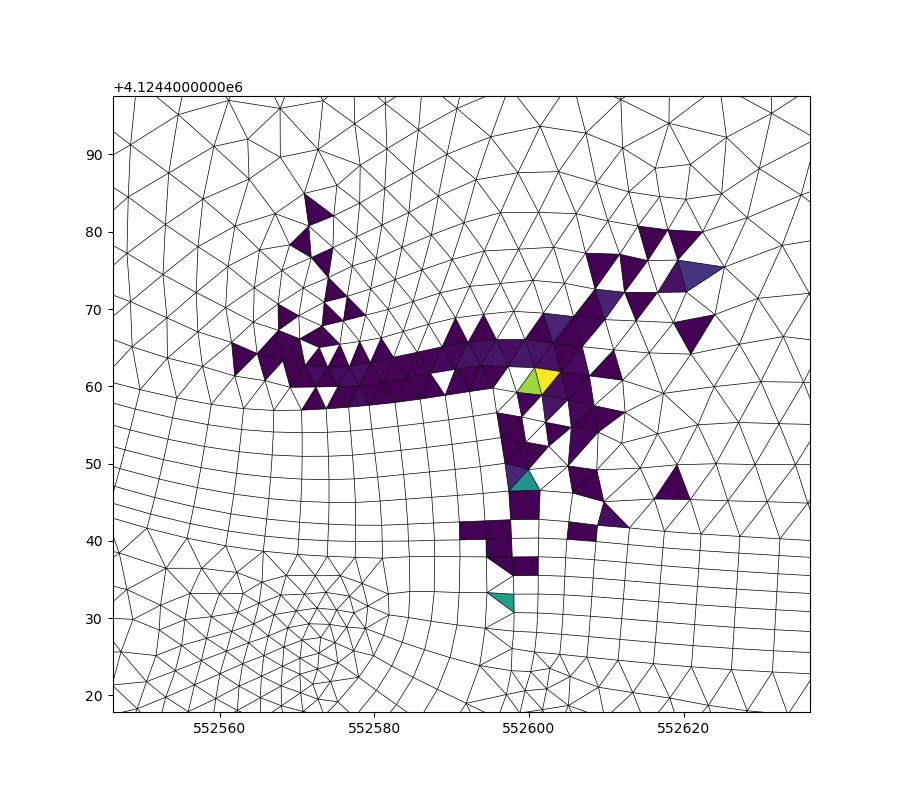

In [81]:
fig,ax=plt.subplots(figsize=(9,8))
ax.set_adjustable('datalim')
g0.plot_edges(color='k',lw=0.5)

bad_cells=steps0.groupby('kkcflmx,').size().sort_values().reset_index().values
bad_cells # [1-based index, times limiting...]
bad_cells=bad_cells[bad_cells[:,0]>0] # drop times proc 0 wasn't limiting


limiting=np.full(g0.Ncells(),np.nan)
limiting[bad_cells[:,0]-1]=bad_cells[:,1]

g0.plot_cells(values=limiting,mask=np.isfinite(limiting))

So all of the limiting cells on proc 0 are on the upstream side of PCH, but not at the gate itself.
More like an issue related to NM draining?

One potential issue is that the marsh is at high stand, with a 0.4m+ deep surface layer, and 0.03m layers below that.

In [11]:
# Take a closer look at the most limiting cell: 3280-1
ti=79
#c=2640-1
c=3351-1
#c=1000

bad=ds0.isel(mesh2d_nFaces=c)
print(f"flowelem bl: {bad.mesh2d_flowelem_bl.values}")
print(f"flowelem_ba: {bad.mesh2d_flowelem_ba.values}")
print(f"s1: {bad.mesh2d_s1.isel(time=ti).values}")
vols=bad.mesh2d_vol1.isel(time=ti).values
print(f"volumes: {vols}")
print(f"     dz: {vols / bad.mesh2d_flowelem_ba.values}")
print(f" number of wet layers: {(np.isfinite(vols)&(vols>0.0)).sum()}")

print(f" salinity: {bad.mesh2d_sa1.isel(time=ti).values}")

flowelem bl: 1.4803573092459574
flowelem_ba: 5.790963585185652
s1: 3.366494002342053
volumes: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.20268373 0.20268373 0.20268373 0.20268373
 0.20268373 0.20268373 0.20268373 0.20268373 0.20268373 0.20268373
 0.20268373 0.20268373 0.20268373 0.20268373 0.20268373 0.20268373
 0.20268373 0.20268373 0.20268373 0.20268373 0.20268373 0.20268373
 0.20268373 0.20268373 0.20268373 0

<IPython.core.display.Javascript object>


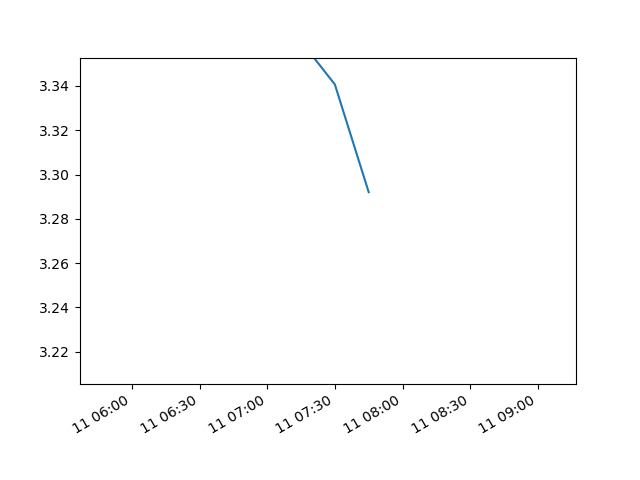

In [14]:
fig=plt.figure()
plt.plot(his_ds.time,his_ds.waterlevel.sel(stations='nck'))
plt.plot(his_ds.time,his_ds.waterlevel.sel(stations='nck'))
fig.autofmt_xdate()

In [22]:
df.head()

,t_minutes,"dts,","dtsc,","kkcflmx,",layer,"vol1(kcflmx),","squ2D(kcflmx),","squ(kcflmx),",sqi(kcflmx)
16237,230811.3655,1.5039,2.2305,3280,24.0,0.2023,0.2941,0.0363,0.0363
16238,230811.3905,1.6532,2.1617,3280,24.0,0.2023,0.2950,0.0374,0.0374
16239,230811.4181,1.8060,2.0933,3280,24.0,0.2023,0.2961,0.0387,0.0387
16240,230811.4482,1.9732,2.0267,3280,24.0,0.2023,0.2971,0.0399,0.0399
16241,230811.4811,1.9550,1.9632,3280,24.0,0.2023,0.2982,0.0412,0.0412


<IPython.core.display.Javascript object>


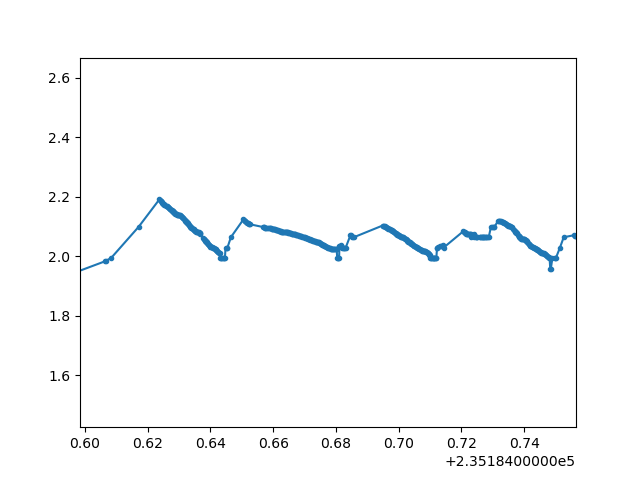

In [34]:
# step output over time
cell=3280
Ac=ds0.mesh2d_flowelem_ba.isel(mesh2d_nFaces=cell-1).values
z0=ds0.mesh2d_flowelem_bl.isel(mesh2d_nFaces=cell-1).values

dz=0.035

df=steps0[ steps0['kkcflmx,']==cell]
df=df.rename({'time0/60,':'t_minutes','dtsc,':'dtsc','dts,':'dts',
              'kcflmx-kbot(kkcflmx)+1,':'layer',
             'vol1(kcflmx),':'vol1'},axis=1)
df=df[ df.dtsc==df.dts] # only when it's really limiting

fig,ax=plt.subplots()

ax.plot(df.t_minutes,z0+df.layer*dz + df['vol1']/Ac , marker='.')

Map output during times of trouble
--

Salinity looks okay.

Freesurface is nutty - there's a spot of 1.5m, just north of the south ditch, surrounded by 3.0m.

This coincides with one of those depressions in the marsh, and not far from the low levee.

How does the position of hydraulic structures compare? Maybe the ditch structure is causing a hydraulic jump -- looks weird, but it's not the heart of the issues.

There is a large jet emanating from the corner of the fixed weir, with max velocities of
60 m/s. That would be the problem.

The fixed weir seems to sit up considerably higher than the DEM. Is that correct?


In [37]:
import stompy.model.delft.io as dio

@utils.add_to(model)
def load_fixed_weirs_from_run(self):                                                                                                                                       
    fw_file=self.mdu.filepath( ('geometry','FixedWeirFile') )                                                                                                              
    if fw_file is None or not os.path.exists(fw_file):                                                                                                                     
        return                                                                                                                                                             

    self.fixed_weirs=dio.read_pli(fw_file)
    
model.load_fixed_weirs_from_run()
fw=model.fixed_weirs

<IPython.core.display.Javascript object>


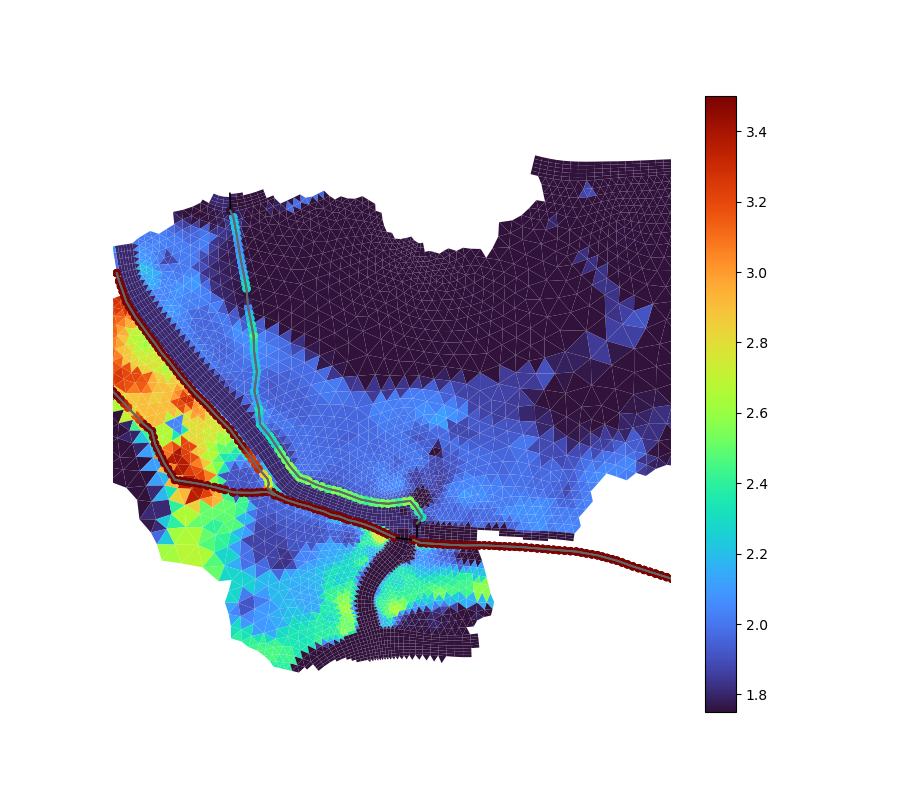

(552539.8948344622, 552669.3001502095, 4124394.4326154226, 4124537.288662914)

In [51]:
ti=80
zoom=(552539.8948344622, 552669.3001502095, 4124394.4326154226, 4124537.288662914)

fig,ax=plt.subplots(figsize=(9,8))
ax.set_adjustable('datalim')
ax.axis('off')


#scal=ds0['mesh2d_sa1'].isel(time=ti)
#scal=np.nanmax(scal,axis=1)
#print(f"{np.isnan(scal).sum()} of {len(scal)} depth-max salinity is nan")

#scal=ds0['mesh2d_s1'].isel(time=ti)

scal=ds0['mesh2d_flowelem_bl']

#scal=ds0['mesh2d_ucmag'].isel(time=ti) # 60 m/s!!!
#scal=np.nanmax(scal,axis=1)

# scal=ds0['mesh2d_waterdepth'].isel(time=ti)

coll=g0.plot_cells(values=scal,cmap='turbo')
plt.colorbar(coll)

if 1:
    for struct in model.structures:
        ax.plot(struct['geom'][:,0], 
                struct['geom'][:,1],'k-',lw=1.25)
        
if 1:
    scats=[]
    for fw in model.fixed_weirs:
        ax.plot(fw[1][:,0],fw[1][:,1],color='0.4',lw=1.25)
        scat=ax.scatter(fw[1][:,0],fw[1][:,1],25,fw[1][:,2],cmap='turbo')
        scats.append(scat)
    clim=[1.75,3.5]
    plt.setp(scats,clim=clim)
    coll.set_clim(clim)

ax.axis(zoom)

In [64]:
ls {local_config.bathy_dir}

bathy-overview.png                     dem-scenarios.dbf
cbec-survey-interp-grid15.pkl          dem-scenarios.prj
cbec-survey-interp-grid7.pkl           dem-scenarios.qpj
cbec-survey-interp-grid8.pkl           dem-scenarios.shp
cbec-survey-interp-grid9.pkl           dem-scenarios.shx
cbec_vs_UCB.png                        interp_lagoon.py
compiled-dem-asbuilt-20210920-1m.tif   lagoon-1m.tif
compiled-dem-existing-20210920-1m.tif  lagoon-interp-1m.tif
compile_dem.py                         north_channel_and_ditch-1m.tif
compile_scenario_dems.py               north_channel-interp-1m.tif
dem-polygons.dbf                       plot_region.py
dem-polygons.prj                       scen2/
dem-polygons.qpj                       scen2-delta-zoomed.png
dem-polygons.shp                       scen3/
dem-polygons.shx                       scen3-delta-zoomed.png
dem-scenarios.cpg                      topo-colorbar.png


In [54]:
import local_config
from stompy.spatial import field

scenario='scen3'
scen_overlay=os.path.join(local_config.bathy_dir,scenario,'output_res1.tif')
dem_overlay=field.GdalGrid(scen_overlay)

In [65]:
base_dem_fn=os.path.join(local_config.bathy_dir,"compiled-dem-asbuilt-20210920-1m.tif")
base_dem=field.GdalGrid(base_dem_fn)

In [79]:
model.load_fixed_weirs_from_run()
model_base.load_fixed_weirs_from_run()


<IPython.core.display.Javascript object>


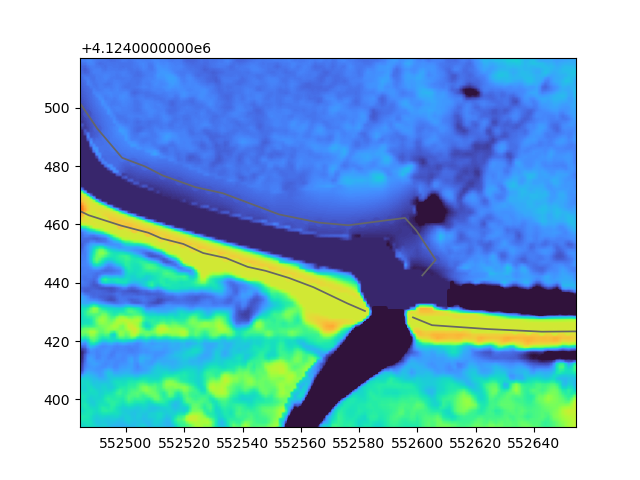

(552484.211038931, 552654.4918202534, 4124390.4074156415, 4124517.2940623686)

In [83]:
fig,ax=plt.subplots()
ax.set_adjustable('datalim')


img=dem_overlay.plot(cmap='turbo',ax=ax)
#img=base_dem.plot(cmap='turbo',ax=ax)

scats=[]
for fw in model.fixed_weirs:
    ax.plot(fw[1][:,0],fw[1][:,1],color='0.4',lw=1.25)
    scat=ax.scatter(fw[1][:,0],fw[1][:,1],25,fw[1][:,2],cmap='turbo')
    scats.append(scat)

clim=[1.75,3.5]
plt.setp(scats,clim=clim)
img.set_clim(clim)
ax.axis((552484.211038931, 552654.4918202534, 4124390.4074156415, 4124517.2940623686))

In [81]:
ax.axis()


(552484.211038931, 552654.4918202534, 4124390.4074156415, 4124517.2940623686)